# Quicklook lightcurve of K2 C16 Supernovae

By Jessie Dotson at `#TESSninja`, modified by gully on March 13.

This notebook demonstrates how to make a quicklook lightcurve from the C16 raw data quicklook target pixel file.

First, we load the Python packages we'll need.  We'll make use of the brand new `lightkurve` package (see http://lightkurve.keplerscience.org).  You can obtain this package using:

```pip install lightkurve```

List of K2 C16 Supernovae:

|object| IAU Name | EPIC ID| Notes|
|--|--|--|   |
|PS17fjs|SN 2017jeb|212024618|  Hard to see |
|PS17fkc|AT 2017jgi|211545516|   |
|PS17fke|AT 2017jgj|212041154|   |
|PS17fkd|AT 2017jgh|211427218|   |
|PS17fiq|SN 2017ixf|211609673|   |
|PS17fin|AT 2017iwx||   |
|PS17fim|SN 2017iws||   |
|PS18eo|SN 2018hb||   |
|PS18ep|SN 2018ha||   |
|PS18eq|SN 2018hc||   |
|C16-0012|AT 2018mn|211512266|   |
|PS18ir|AT 2018uc|251353458|   |
|C16-0041|AT 2018ns|211579863|   |
|C16-0063|AT 2018py|211845074|   |
|C16-0064|AT 2018pz|212184937|   |
|C16-0051|AT 2018uv||   |
|C16-0060|AT 2018qb|212051579|   |
|ASASSN-18bt|SN 2018oh|251809520|   |
|C16-0043|SN 2018nt||   |
|C16-0012|AT 2018mn|211512266|   |
|C16-0062|AT 2018qa| |   |



In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from lightkurve import KeplerTargetPixelFile, LightCurve

In [3]:
import glob

Next, we'll load the quicklook target pixel file for the host galaxy of the supernova:

In [4]:
fns = glob.glob('/Volumes/Truro/C16/quicklook.keplerscience.org/c16-galaxies/*.fits.gz')
len(fns)

8380

In [5]:
fn_array = np.array(fns)

In [156]:
sn_mask = np.array(['211512266' in fn for fn in fns])
sn_mask.sum()

1

In [292]:
fn = fn_array[sn_mask][0]
fn = fns[999+4]

In [293]:
fn

'/Volumes/Truro/C16/quicklook.keplerscience.org/c16-galaxies/ktwo211524207-unofficial-tpf.fits.gz'

In [294]:
tpf = KeplerTargetPixelFile(fn)

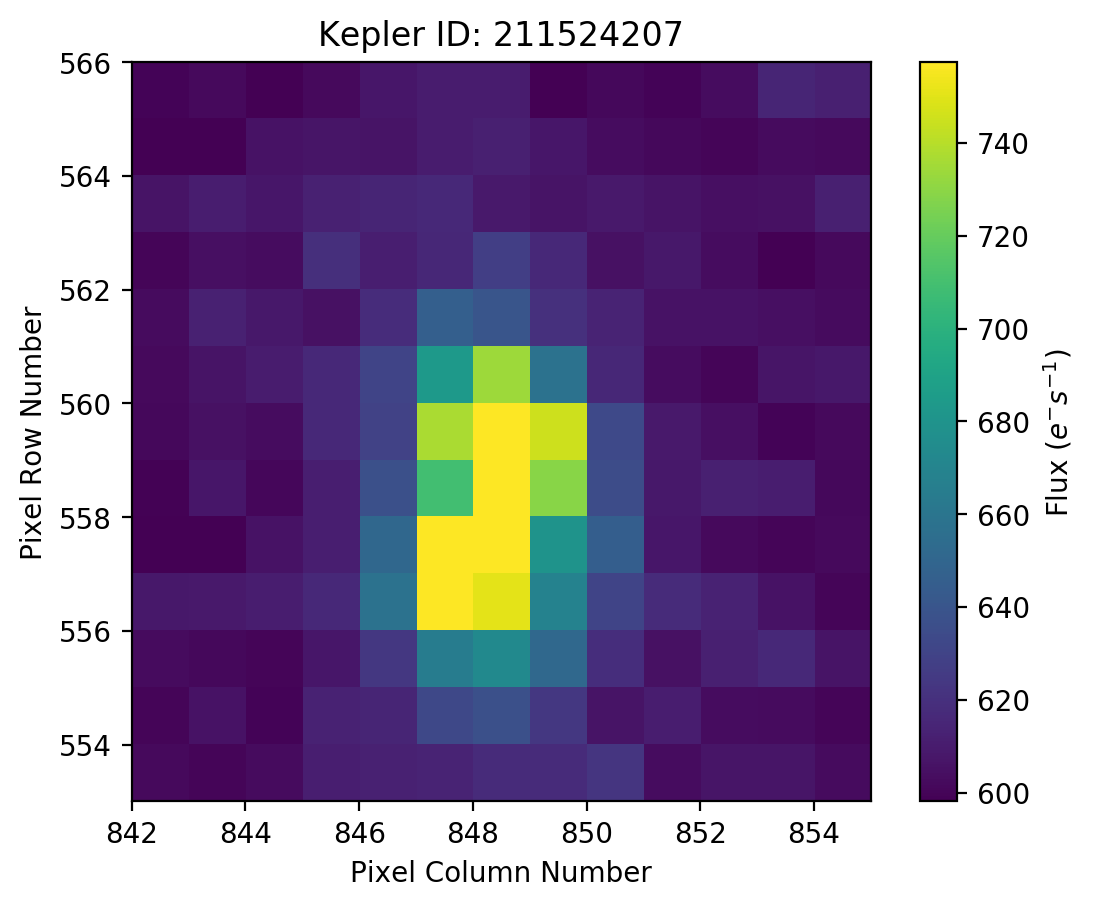

In [295]:
tpf.plot();

Next, we define a simple square aperture mask we'll use to carry out aperture photometry:

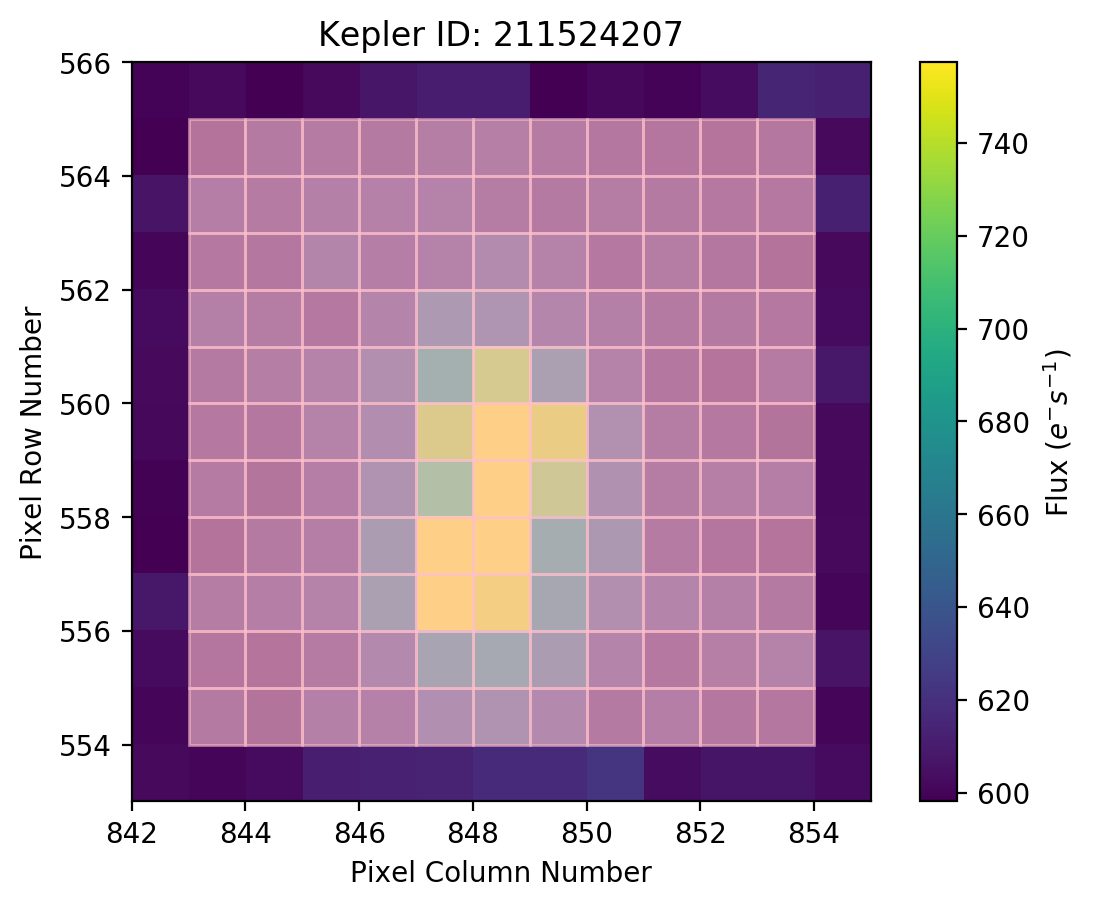

In [296]:
# We know the supernova is near the center, so define a central aperture mask
core_mask = tpf.pipeline_mask
core_mask[1:-1, 1:-1] = True
tpf.plot(aperture_mask=core_mask);

We also define an aperture mask to estimate the background flux:

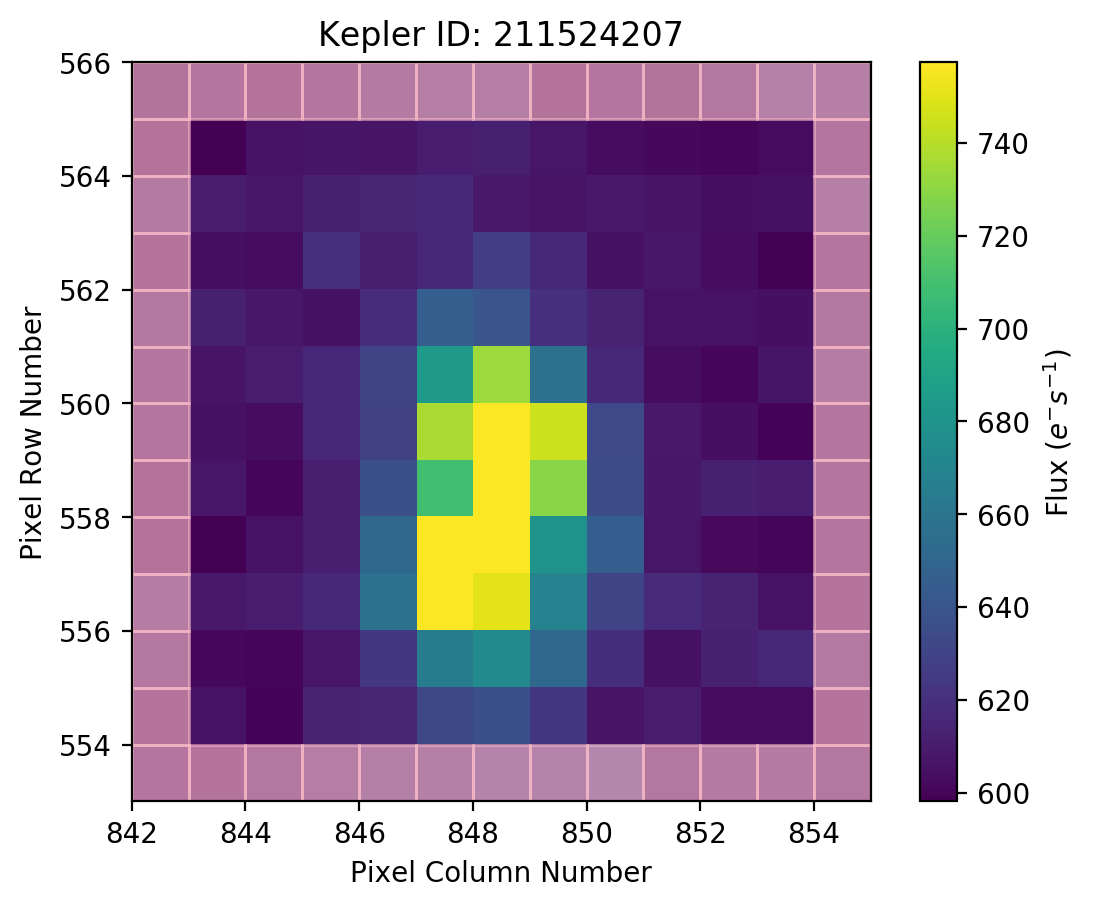

In [297]:
finite_mask = np.alltrue(tpf.flux==tpf.flux, axis=0)

bg_mask = tpf.pipeline_mask * False
bg_mask[0, :] = True
bg_mask[-1, :] = True
bg_mask[:, 0] = True
bg_mask[:, -1] = True
bg_mask = bg_mask & finite_mask
tpf.plot(aperture_mask=bg_mask);

Next, we perform aperture photometry using the `to_lightcurve` method, and subtract the background flux from the supernova lightcurve:

In [298]:
core_lc = tpf.to_lightcurve(aperture_mask=core_mask) / core_mask.sum()  # Divide by number of pixels in aperture
bg_lc = tpf.to_lightcurve(aperture_mask=bg_mask) / bg_mask.sum()
sn_lc = core_lc - bg_lc.flux

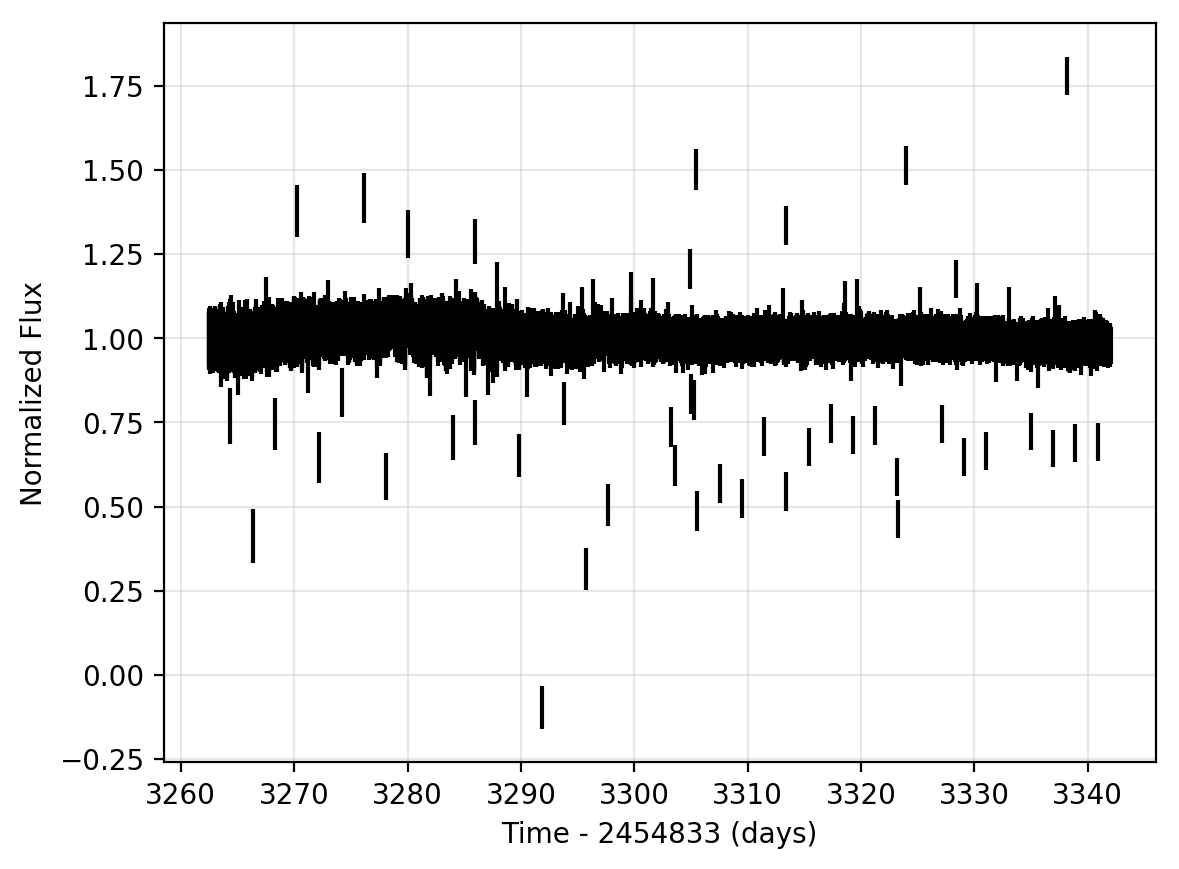

In [299]:
sn_lc.plot(linestyle="None");

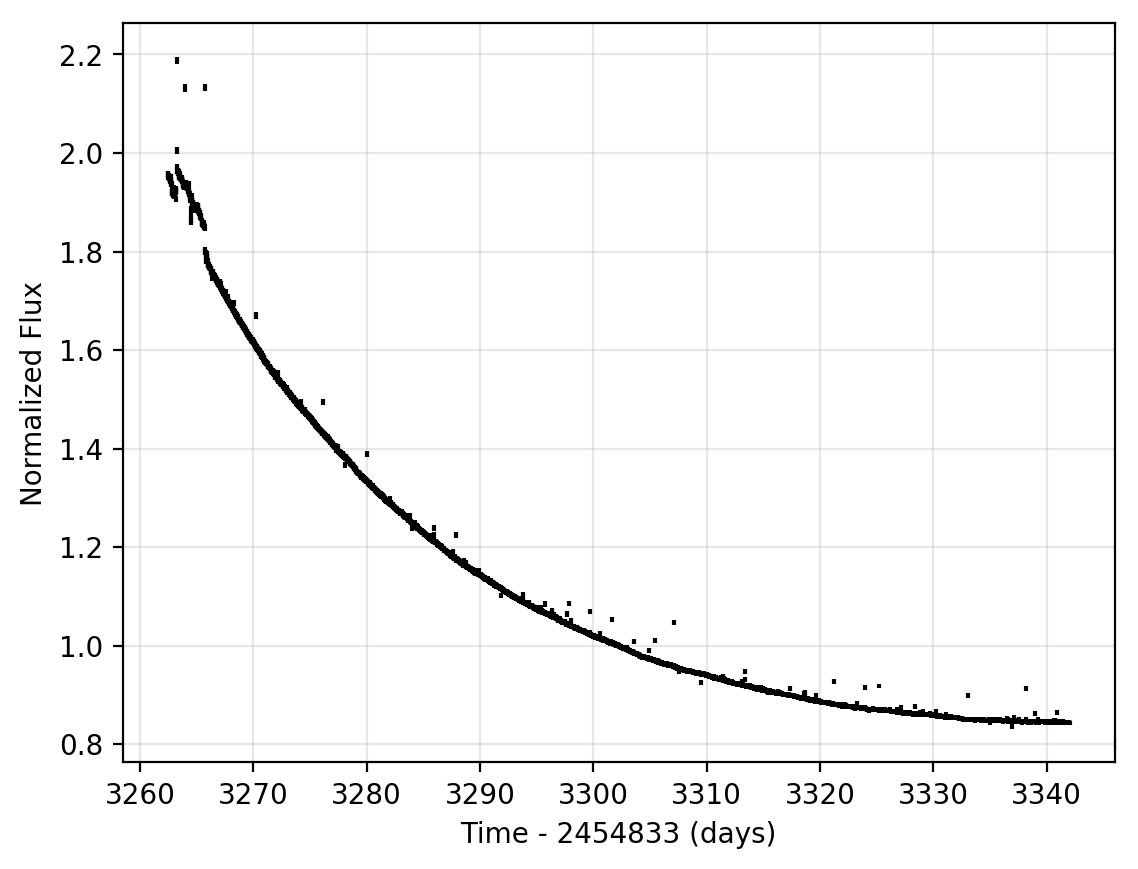

In [300]:
core_lc.plot(linestyle='none');

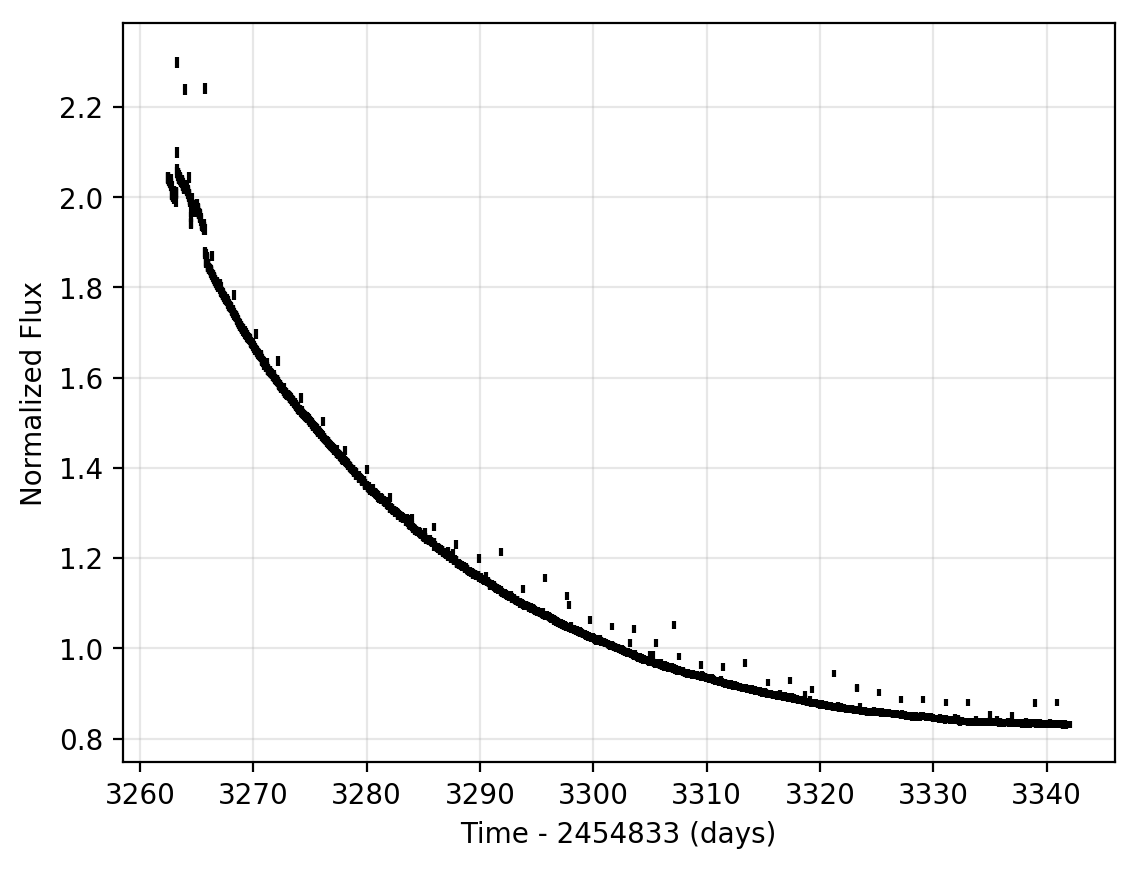

In [301]:
bg_lc.plot(linestyle='none');

The lightcurve contains outliers due to the motion of the Kepler spacecraft.  We experimentally determined the outlier cadences in another notebook, so we can simply read in the file and use those cadences as a mask

In [302]:
n_cadences = tpf.time.size

In [303]:
cadn = np.arange(0, n_cadences, 1)

In [304]:
outlier_frame = pd.read_csv('./C16_unofficial_thruster_firing_mask.csv')
outlier_frame.head(3)

,outlier_cadence,prob_outlier
0,93,0.777446
1,186,0.775895
2,282,0.534845


In [305]:
outlier_mask_thruster = np.isin(cadn, outlier_frame.outlier_cadence)

Some outliers remain-- we should consider using a mask determined from sigma clipping the flux of a nearby star.

In [306]:
_, outlier_mask_sigma_clip = sn_lc.flatten().remove_outliers(return_mask=True, sigma=3)

The flux sigma-clipping on the galaxy itself found additional outliers, and found 38/40 of the previously identified thruster cadences.

In [307]:
outlier_mask_thruster.sum(), outlier_mask_sigma_clip.sum(), (outlier_mask_sigma_clip & outlier_mask_thruster).sum()

(40, 140, 40)

Let's use the combination of these two masks.

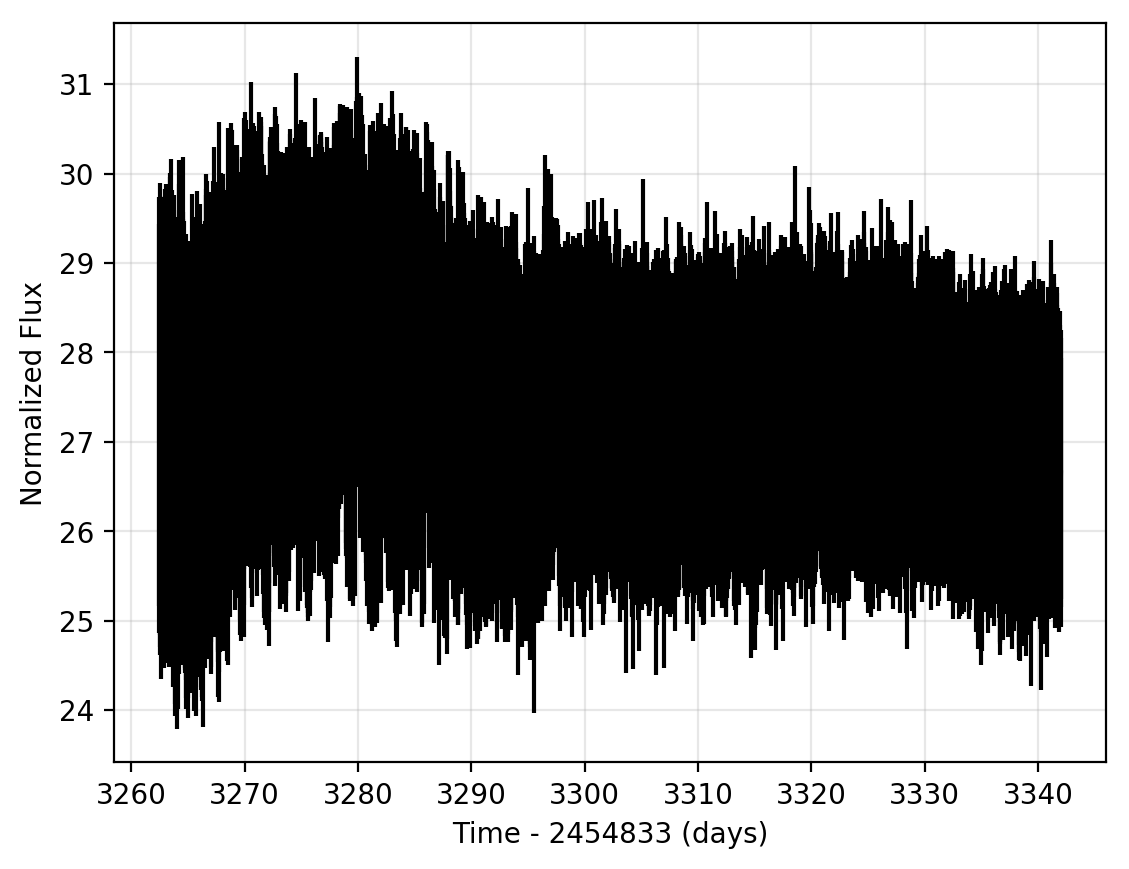

In [308]:
outlier_mask = outlier_mask_thruster | outlier_mask_sigma_clip
sn_lc[~outlier_mask].plot(normalize=False);

Success!  Drop the outliers.

In [309]:
sn_lc = sn_lc[~outlier_mask]

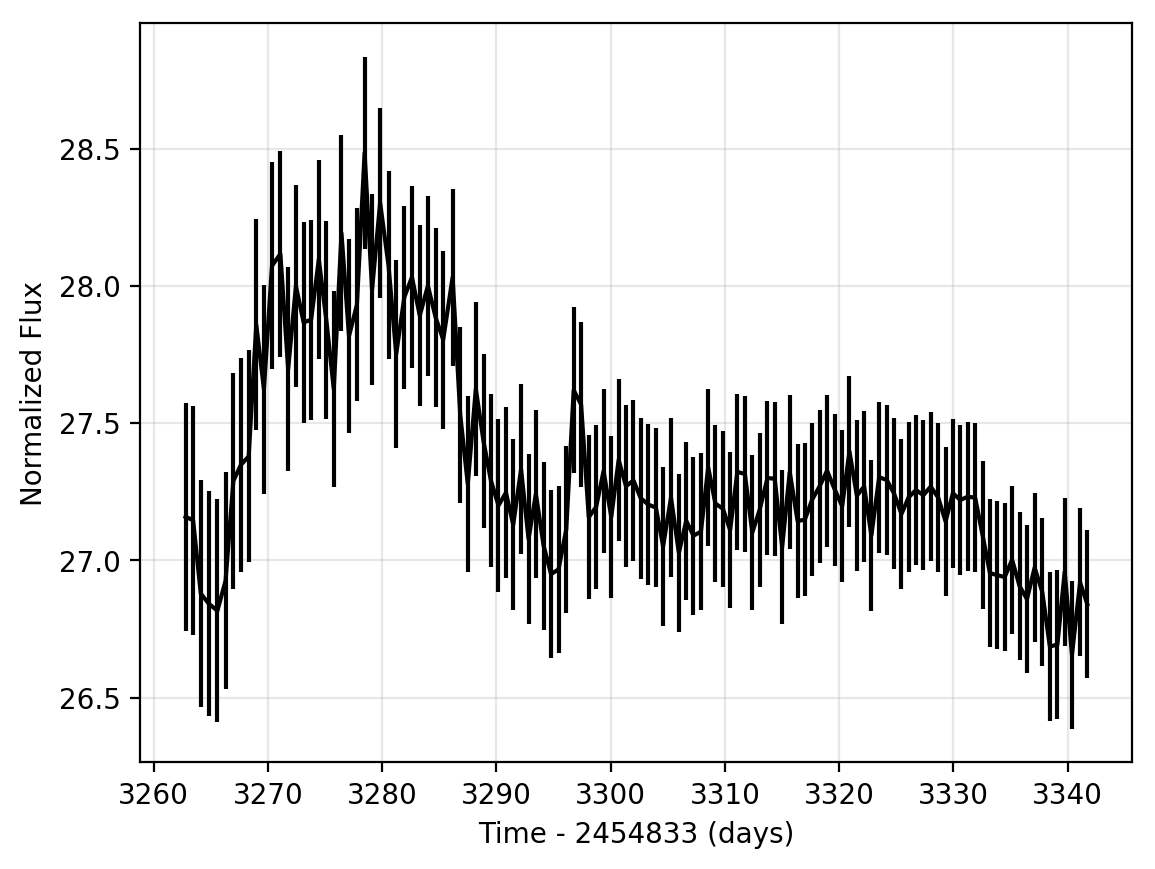

In [310]:
sn_lc.bin(31).plot(normalize=False);

## Is the supernova detected in the galaxy's centroid position?

In [311]:
col_offset = np.median(sn_lc.centroid_col) - sn_lc.centroid_col
row_offset = np.median(sn_lc.centroid_row) - sn_lc.centroid_row

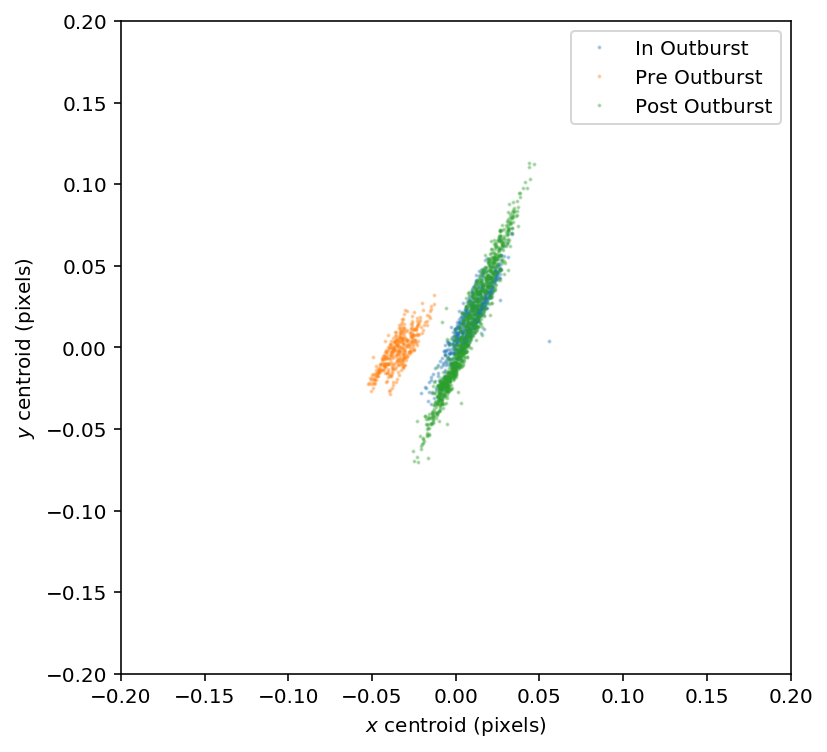

In [312]:
categories = {'In Outburst':(sn_lc.time > 3280) & (sn_lc.time < 3295), 
              'Pre Outburst':(sn_lc.time < 3270), 
              'Post Outburst':(sn_lc.time > 3320)}

scl=plt.figaspect(1)
plt.figure(figsize=scl*1.5)

for key in categories.keys():
    mask = categories[key]
    plt.plot(row_offset[mask], col_offset[mask], '.', label=key, ms=2, alpha=0.3)
plt.legend();
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)
plt.xlabel('$x$ centroid (pixels)');
plt.ylabel('$y$ centroid (pixels)');

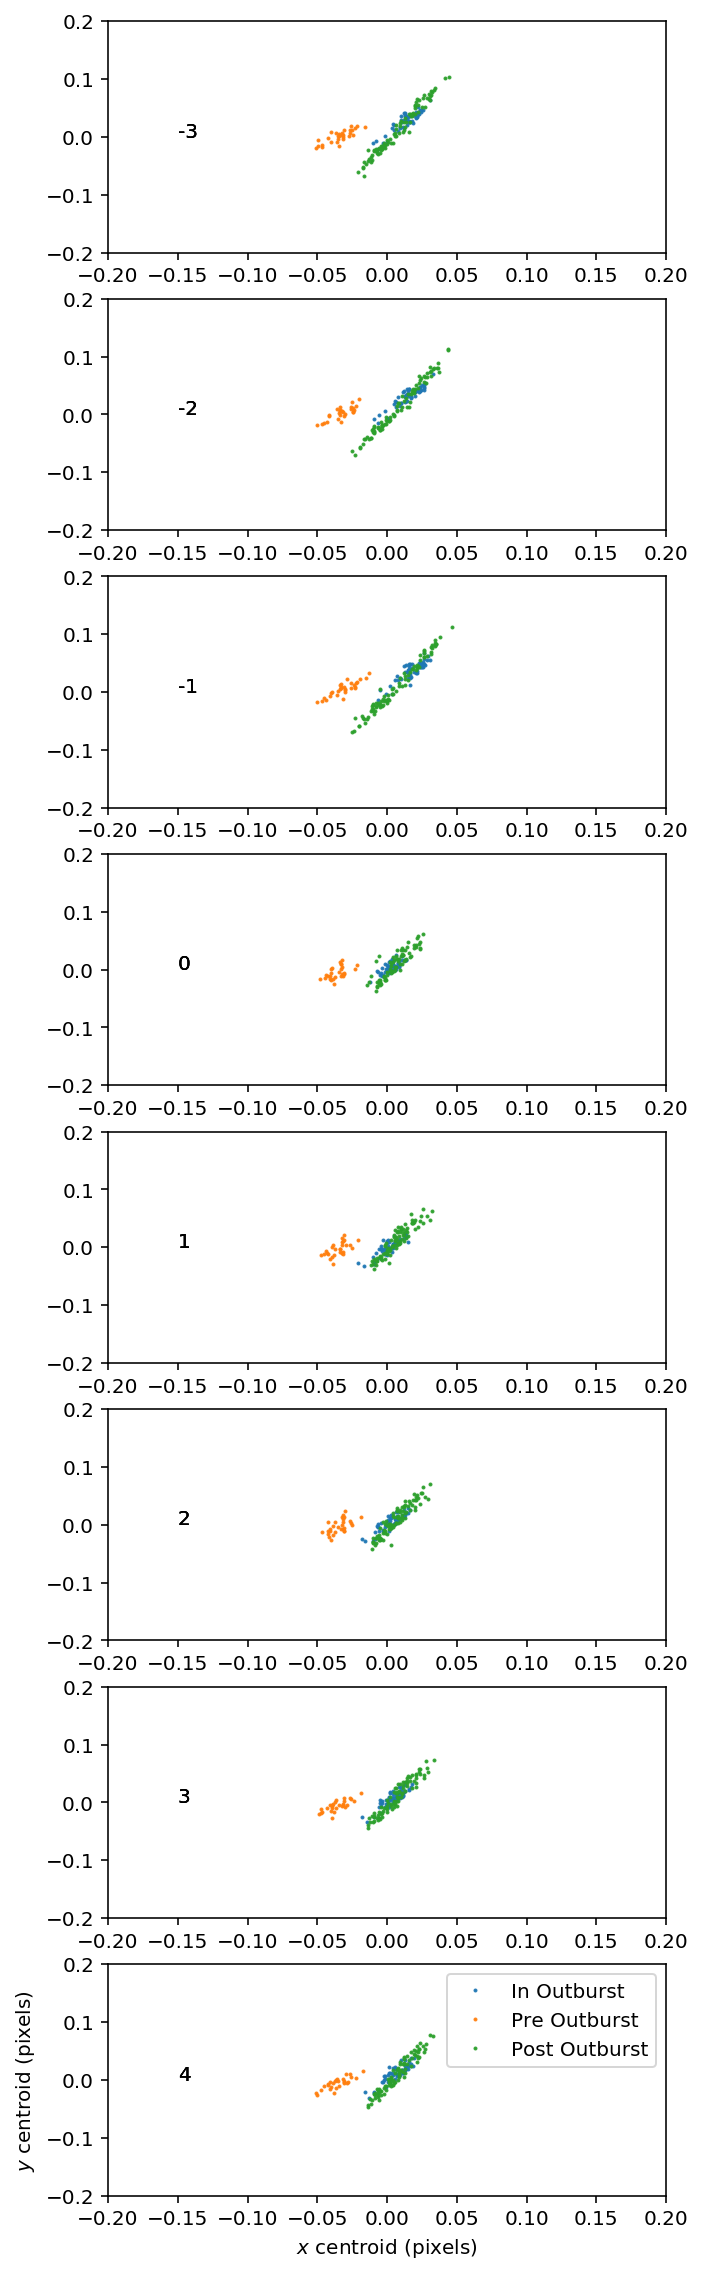

In [313]:
delta = -1
pred_thruster_fires_1 = (cadn < 2678) & (np.mod(cadn, 12) == 6+delta)
pred_thruster_fires_2 = (cadn > 2678) & (np.mod(cadn, 12) == 3+delta)
pred_thruster_fires = pred_thruster_fires_1 | pred_thruster_fires_2

#scl=plt.figaspect(1)
#plt.figure(figsize=scl*1.5)
plt.figure(figsize=(5, 20))
plt.subplot(811)
for key in categories.keys():
    mask1 = categories[key]
    for i, delta in enumerate(np.arange(-3, 5, 1)):
        plt.subplot(811+i)
        pred_thruster_fires_1 = (cadn < 2678) & (np.mod(cadn, 12) == 6+delta)
        pred_thruster_fires_2 = (cadn > 2678) & (np.mod(cadn, 12) == 3+delta)
        pred_thruster_fires = pred_thruster_fires_1 | pred_thruster_fires_2
        mask2 = pred_thruster_fires[~outlier_mask]
        mask = mask1 & mask2
        #print("Key: {} delta: {} std: {:0.3f} {:0.3f}".format(key, delta, 
        #                                            np.std(row_offset[mask]), np.std(col_offset[mask])))
        plt.plot(row_offset[mask], col_offset[mask], '.', label=key, ms=2, alpha=0.9)

        plt.xlim(-0.2, 0.2)
        plt.ylim(-0.2, 0.2)
        plt.text(-0.15, 0, delta)
plt.xlabel('$x$ centroid (pixels)');
plt.ylabel('$y$ centroid (pixels)');
plt.legend();

Hmmm... It's **hard to say**!  The centroid clearly shows a distinct clustering, but the pre- and post- outburst centroids are *also* offset from each other in a way that suggests some natural secular drift in centroid position.

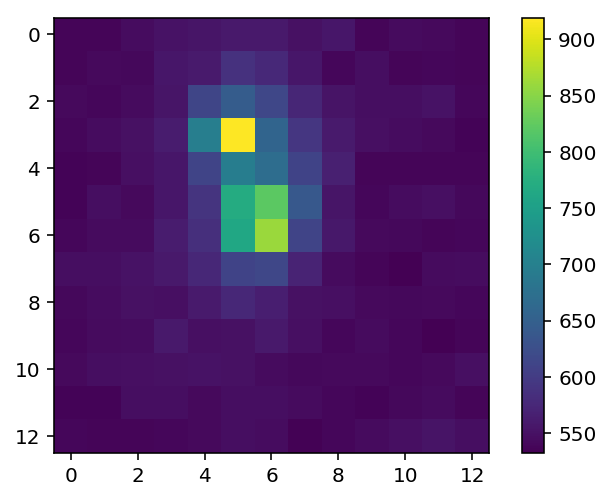

In [314]:
time_mask = categories['Pre Outburst']
preimage = np.nanmedian(tpf.flux[~outlier_mask][time_mask],axis=0)
#preimage = preimage / np.mean(preimage)
plt.imshow(preimage)
plt.colorbar();

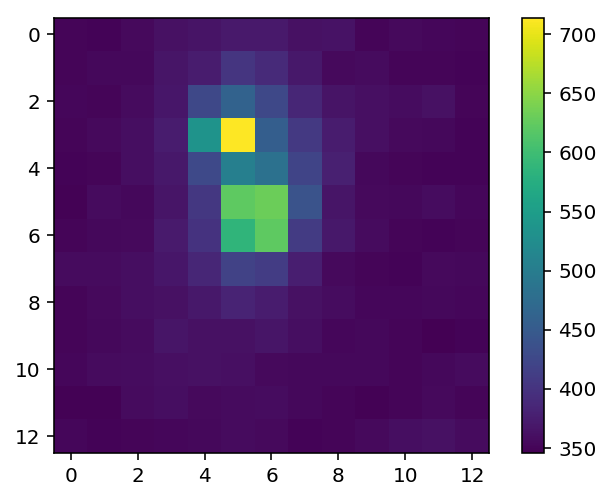

In [315]:
time_mask = categories['In Outburst']
snimage = np.nanmedian(tpf.flux[~outlier_mask][time_mask],axis=0)
plt.imshow(snimage)
plt.colorbar();

In [316]:
difference_image = snimage - preimage

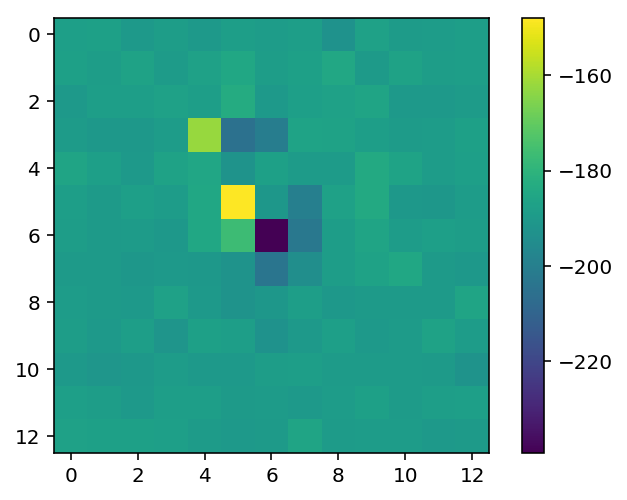

In [317]:
plt.imshow(difference_image)
plt.colorbar();

The above looks promising, but it's a little bit disconcerting that the preimage is brighter than the snimage -- so I think something's wrong here!

### Astrophysical centroid shifts, if present, will complicate motion-based systematics removal

Let's try it anyways.

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


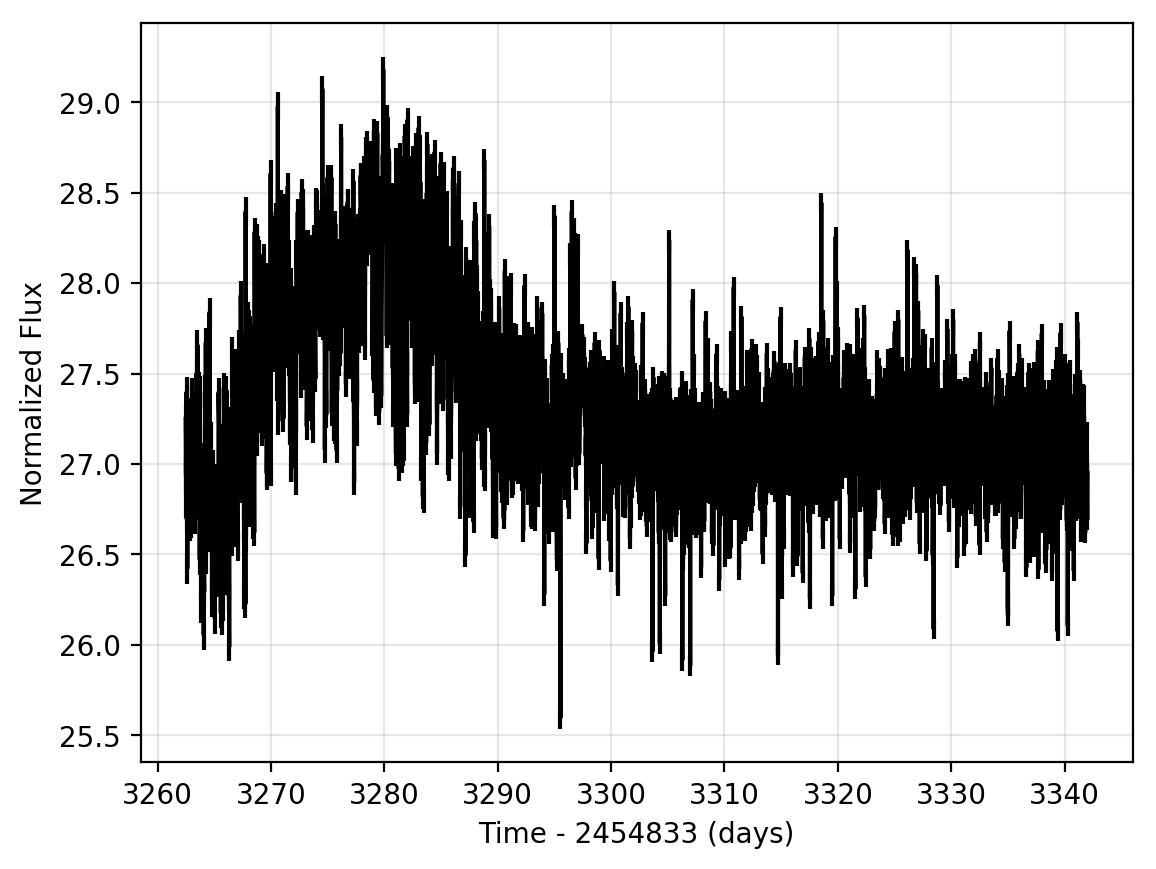

In [318]:
corrected_lc = sn_lc.correct(niters=1, restore_trend=True)
corrected_lc.plot(normalize=False)

Before systematics correction:

(0.9, 1.15)

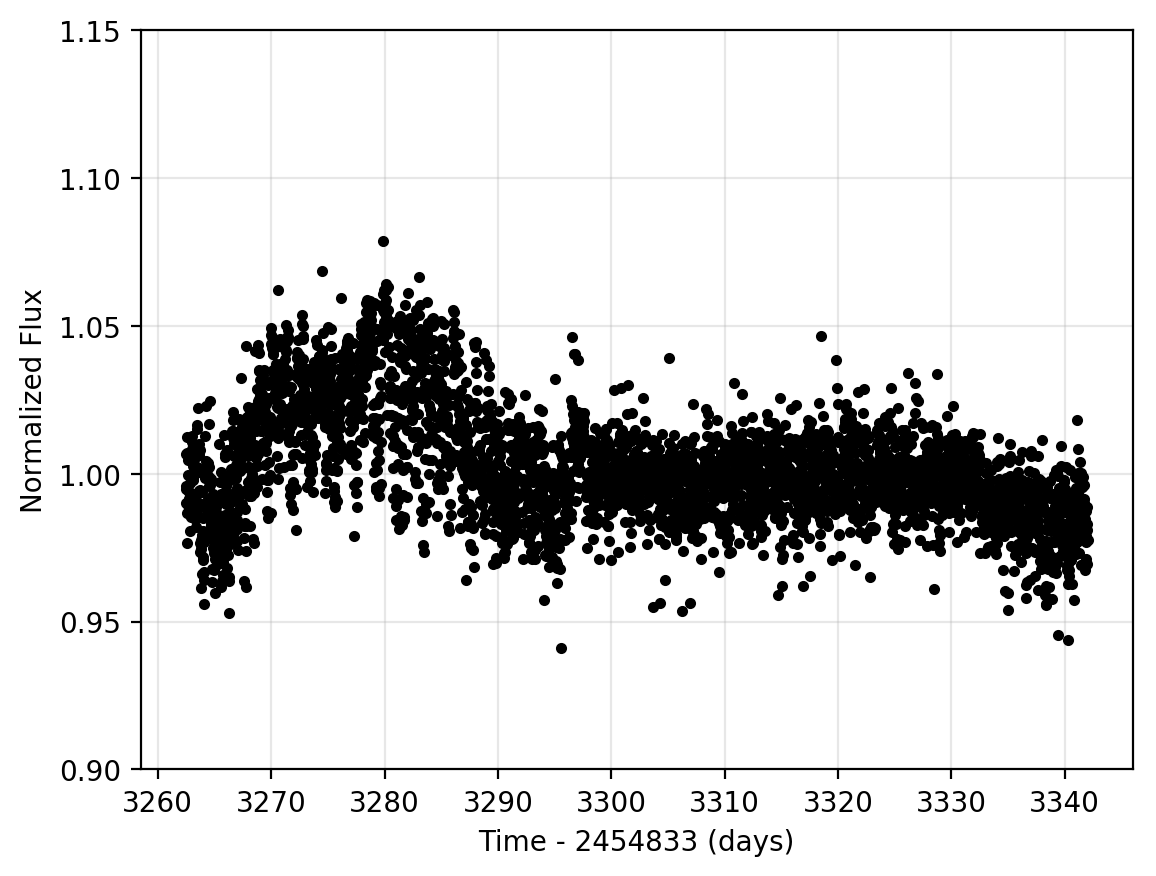

In [319]:
sn_lc.remove_outliers().plot(marker='o', ms=3, lw=0)
plt.ylim([0.9, 1.15])

After systematics correction:

(0.9, 1.15)

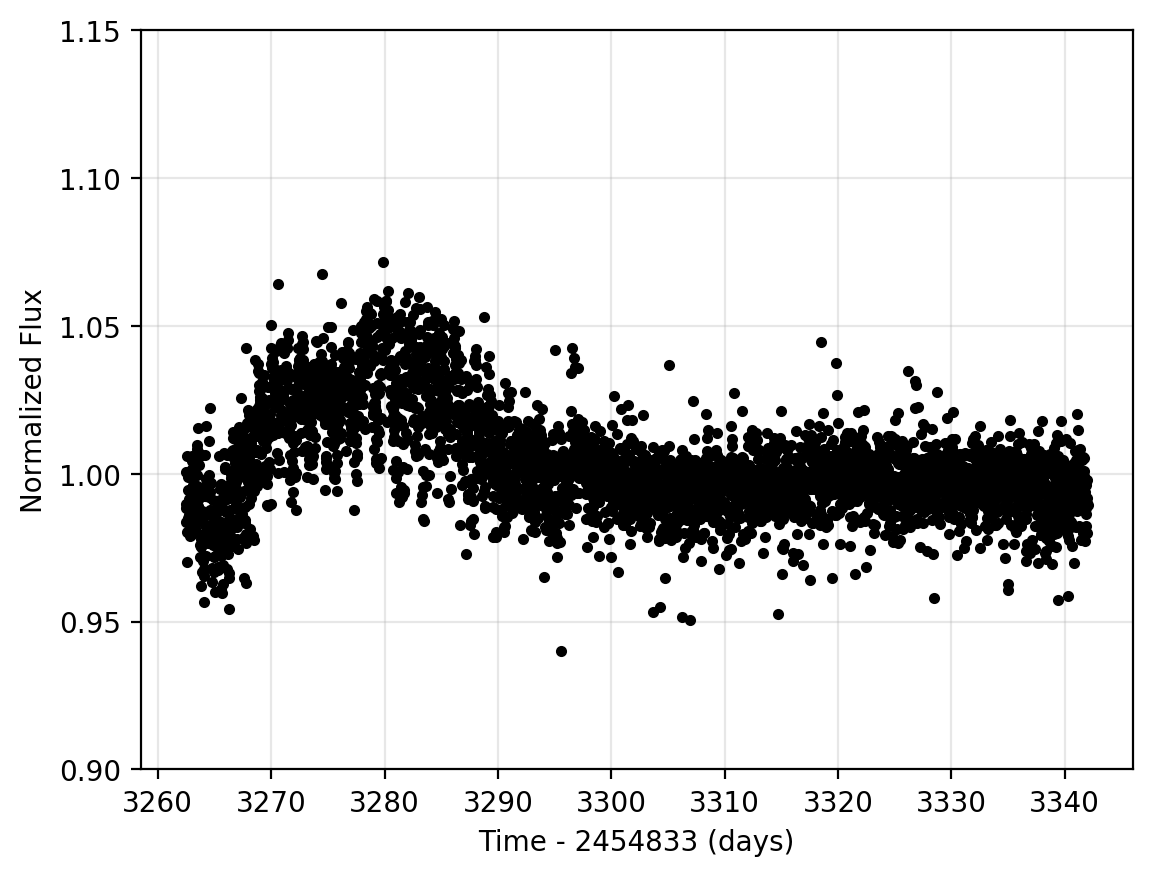

In [320]:
corrected_lc.remove_outliers().plot(marker='o', ms=3, lw=0)
plt.ylim([0.9, 1.15])

In [321]:
binned_lc = corrected_lc.bin()

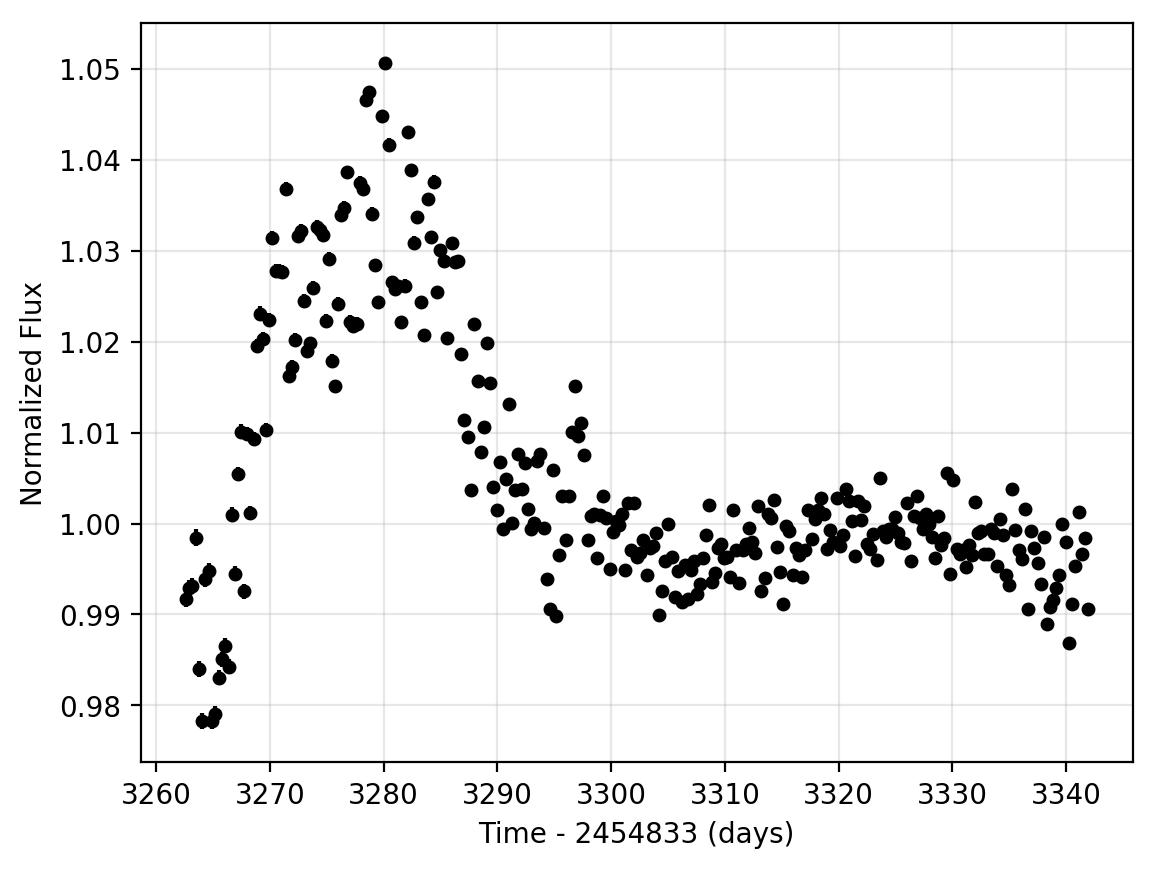

In [322]:
binned_lc.plot(linestyle='none',marker='o',markersize=4)

In [ ]:
sn_lc.

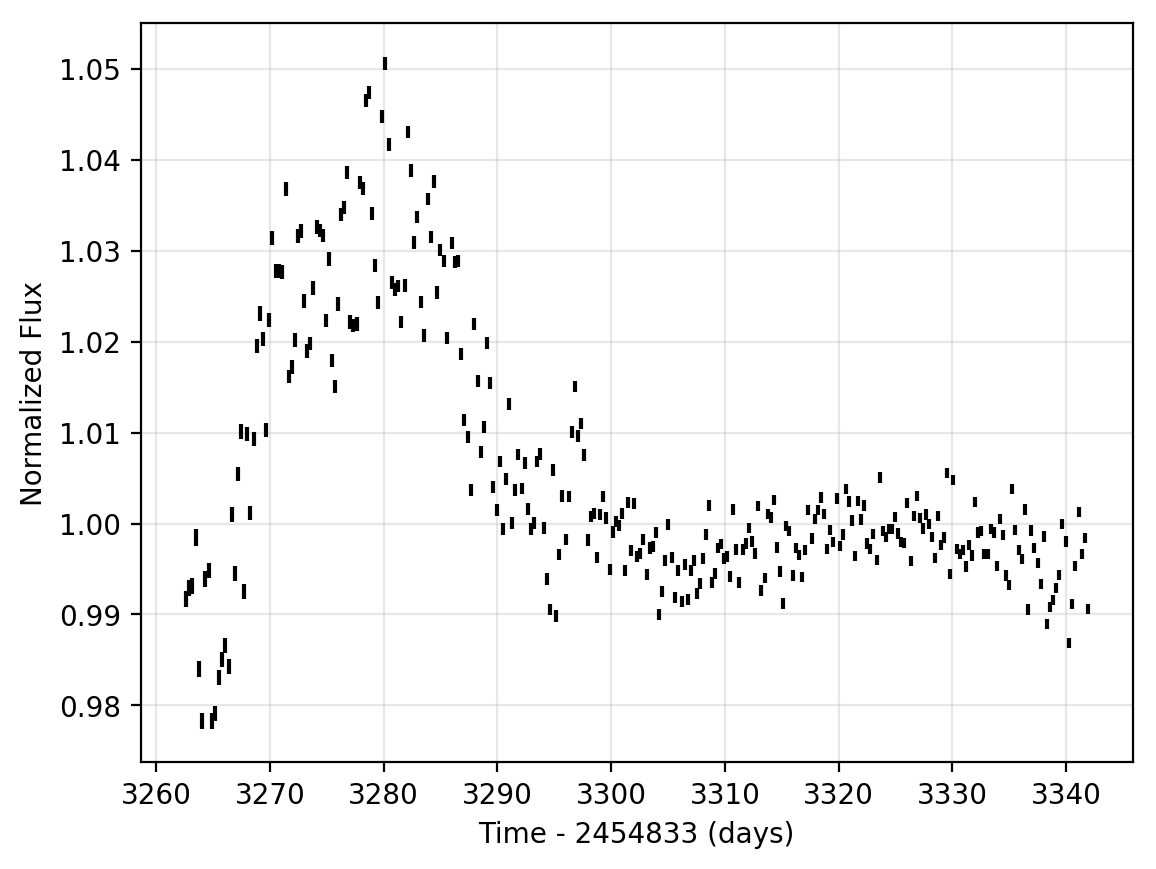

In [323]:
binned_lc.plot(linestyle='none')

Nice